In [1]:
import numpy as np
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import matplotlib.font_manager
import pandas as pd
from scipy import optimize
import seaborn as sns; sns.set(); sns.set_context("talk")

In [37]:
import csv
with open('pokemon_numbers.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    count = 0 
    Class = []
    Instance = []
    Win_Count = []
    Lose_Count = []
    Draw_Count = []
    ELO = []
    Kde_Tier = []
    Diff_Tier = []
    for row in reader: 
        #print(row['Class'])
        Class.append(row['Class'])
        Instance.append(row['Instance'])
        Win_Count.append(row['Win_Count'])
        Lose_Count.append(row['Lose_Count'])
        Draw_Count.append(row['Draw_Count'])
        ELO.append(row['ELO'])
        Kde_Tier.append(row['Kde_Tier'])
        Diff_Tier.append(row['diff_Tier'])
sig0 = 1.
#print()
# Now change the number string to a number list
Class = list(map(float, Class))
ELO = list(map(float, ELO))
Instance = list(map(float, Instance))
Win_Count = list(map(float, Win_Count))
Lose_Count = list(map(float, Lose_Count))
Draw_Count = list(map(float, Draw_Count))
Kde_Tier = list(map(float, Kde_Tier))
Diff_Tier = list(map(float, Diff_Tier))
Class = pd.to_numeric(Class)
Win_Count = pd.to_numeric(Win_Count)
Lose_Count = pd.to_numeric(Lose_Count)
ELO = pd.to_numeric(ELO)

#Based off previous battling data sets the error for each was about 2. 
#e = sig0*np.ones_like(y)

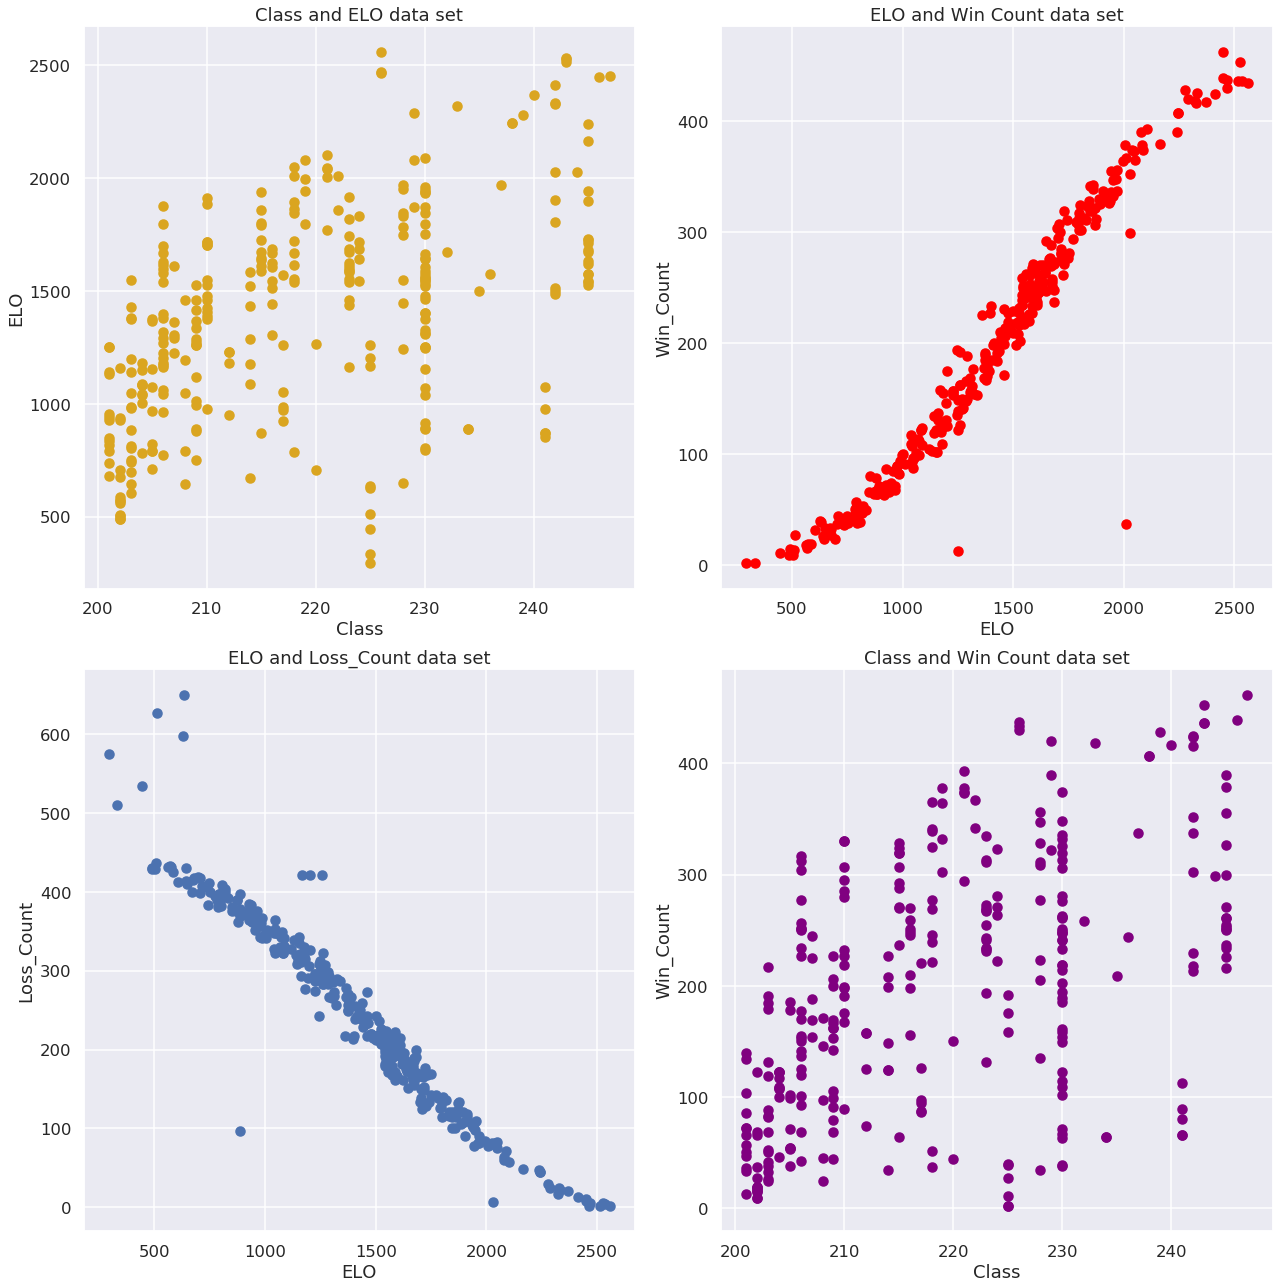

In [61]:
fig, axs = plt.subplots(2, 2, figsize=(18,18))
axs[0, 0].scatter(Class, ELO, color='goldenrod')
axs[0, 0].set(xlabel='Class', ylabel='ELO', title='Class and ELO data set')
axs[0, 1].scatter(ELO, Win_Count, color='red')
axs[0, 1].set(xlabel='ELO', ylabel='Win_Count', title='ELO and Win Count data set')
axs[1, 0].scatter(ELO, Lose_Count)
axs[1, 0].set(xlabel='ELO', ylabel='Loss_Count', title='ELO and Loss_Count data set')
axs[1, 1].scatter(Class, Win_Count, color ='purple')
axs[1, 1].set(xlabel='Class', ylabel='Win_Count', title='Class and Win Count data set')
fig.tight_layout()

## Let's Look, Together, at Outliners

### First, Class and ELO 

MLE: theta0 = -2583.7, theta1 = 18.24


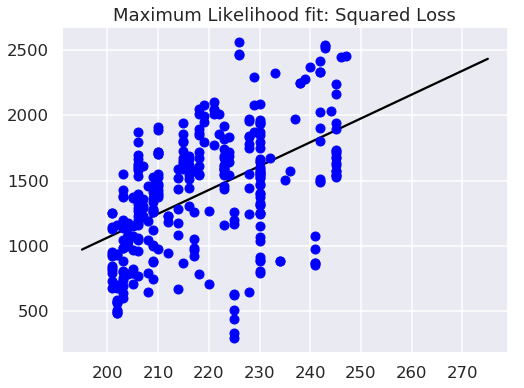

In [47]:
def residuals(theta, Class=Class, ELO=ELO, sigma0=sig0):
    """
    Residuals between data y (a vector at points x) and the theoretical model,
    which here is a straight line with theta[0] = b and theta[1] = m.
    """
    delta_y = ELO - theta[0] - theta[1] * Class
    return delta_y / sigma0

 
def log_posterior_gaussian(theta):
    """
    Returns the logarithm of the posterior, with a standard chi^2 likelihood 
    in terms of the residuals, with Gaussian errors as specified and a
    uniform prior assumed for theta between 0 and 100.
    """
    if (all(theta > 0) and all(theta < 100)):
        return -0.5 * np.sum(residuals(theta)**2)
    else:
        return -np.inf  # recall log(0) = -inf  

def squared_loss(theta, Class=Class, ELO=ELO, sigma0=sig0):
    """Loss function is sum of squared residuals divided by 2, which
        is what we usually call chi^2 / 2. 
    """
    delta_y = ELO - theta[0] - theta[1] * Class
    return np.sum(0.5 * (delta_y / sigma0) ** 2)

theta_MLE = optimize.fmin(squared_loss, [0, 0], disp=False)
print(f"MLE: theta0 = {theta_MLE[0]:.1f}, theta1 = {theta_MLE[1]:.2f}")

# Plot the MLE fit versus the data
xfit = np.linspace(195, 275)
yfit = theta_MLE[0] + theta_MLE[1] * xfit

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.errorbar(Class, ELO, sig0, fmt='o', color='blue')
ax.plot(xfit, yfit, color='black')
ax.set_title('Maximum Likelihood fit: Squared Loss');

Huber: theta0 = -2592.7, theta1 = 18.44


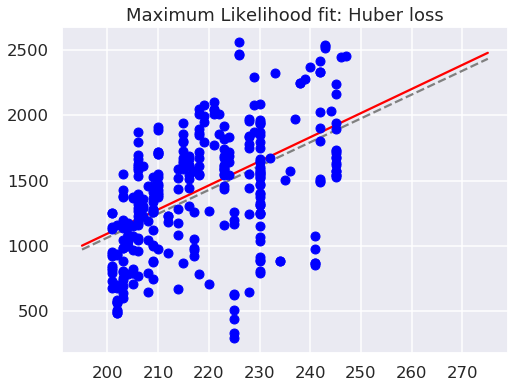

In [48]:
t = np.linspace(-20, 20)

def huber_loss(t, c=3):
    """
    Returns either a squared lost function or a linear (abolute value) loss
     function, depending on whether the |argument| is < c or >= c.
    """
    return ((abs(t) < c) * 0.5 * t ** 2
            + (abs(t) >= c) * -c * (0.5 * c - abs(t)))

def total_huber_loss(theta, Class=Class, ELO=ELO, sigma0=sig0, c=1):
    return huber_loss((ELO - theta[0] - theta[1] * Class) / sigma0, c).sum()

# minimize the total Huber loss for c=3
theta2 = optimize.fmin(total_huber_loss, [0, 0], disp=False)
print(f"Huber: theta0 = {theta2[0]:.1f}, theta1 = {theta2[1]:.2f}")

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(Class, ELO, sig0, fmt='o', color='blue')
ax.plot(xfit, theta_MLE[0] + theta_MLE[1] * xfit, color='gray',ls='--')
ax.plot(xfit, theta2[0] + theta2[1] * xfit, color='red')
ax.set_title('Maximum Likelihood fit: Huber loss');

## ELO and Lose Count 

MLE: theta0 = 603.5, theta1 = -0.25


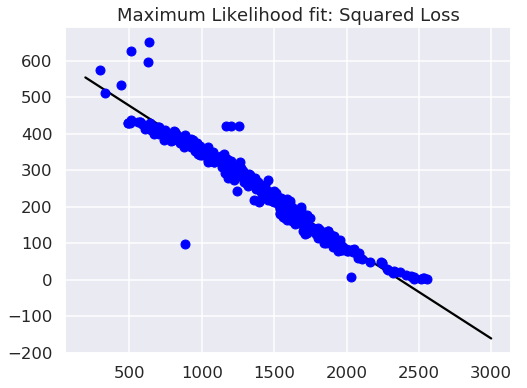

In [43]:
def residuals(theta, ELO=ELO, Lose_Count=Lose_Count, sigma0=sig0):
    """
    Residuals between data y (a vector at points x) and the theoretical model,
    which here is a straight line with theta[0] = b and theta[1] = m.
    """
    delta_y = Lose_Count - theta[0] - theta[1] * ELO
    return delta_y / sigma0

 
def log_posterior_gaussian(theta):
    """
    Returns the logarithm of the posterior, with a standard chi^2 likelihood 
    in terms of the residuals, with Gaussian errors as specified and a
    uniform prior assumed for theta between 0 and 100.
    """
    if (all(theta > 0) and all(theta < 100)):
        return -0.5 * np.sum(residuals(theta)**2)
    else:
        return -np.inf  # recall log(0) = -inf  

def squared_loss(theta, ELO=ELO, Lose_Count=Lose_Count, sigma0=sig0):
    """Loss function is sum of squared residuals divided by 2, which
        is what we usually call chi^2 / 2. 
    """
    delta_y = Lose_Count - theta[0] - theta[1] * ELO
    return np.sum(0.5 * (delta_y / sigma0) ** 2)

theta_MLE = optimize.fmin(squared_loss, [0, 0], disp=False)
print(f"MLE: theta0 = {theta_MLE[0]:.1f}, theta1 = {theta_MLE[1]:.2f}")

# Plot the MLE fit versus the data
xfit = np.linspace(195, 3000)
yfit = theta_MLE[0] + theta_MLE[1] * xfit

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.errorbar(ELO, Lose_Count, sig0, fmt='o', color='blue')
ax.plot(xfit, yfit, color='black')
ax.set_title('Maximum Likelihood fit: Squared Loss');

Huber: theta0 = 595.8, theta1 = -0.25


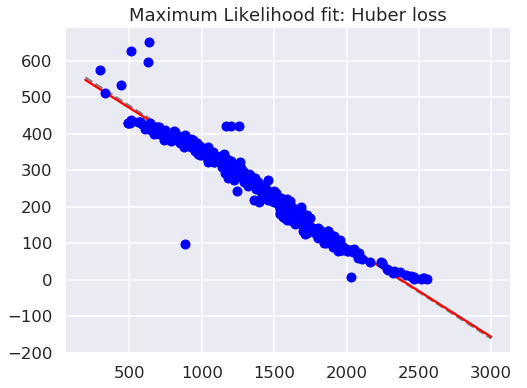

In [44]:
t = np.linspace(-20, 20)

def huber_loss(t, c=3):
    """
    Returns either a squared lost function or a linear (abolute value) loss
     function, depending on whether the |argument| is < c or >= c.
    """
    return ((abs(t) < c) * 0.5 * t ** 2
            + (abs(t) >= c) * -c * (0.5 * c - abs(t)))

def total_huber_loss(theta, ELO=ELO, Lose_Count=Lose_Count, sigma0=sig0, c=1):
    return huber_loss((Lose_Count - theta[0] - theta[1] * ELO) / sigma0, c).sum()

# minimize the total Huber loss for c=3
theta2 = optimize.fmin(total_huber_loss, [0, 0], disp=False)
print(f"Huber: theta0 = {theta2[0]:.1f}, theta1 = {theta2[1]:.2f}")

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(ELO, Lose_Count, sig0, fmt='o', color='blue')
ax.plot(xfit, theta_MLE[0] + theta_MLE[1] * xfit, color='gray',ls='--')
ax.plot(xfit, theta2[0] + theta2[1] * xfit, color='red')
ax.set_title('Maximum Likelihood fit: Huber loss');

## ELO and Win Count 

MLE: theta0 = -137.0, theta1 = 0.24


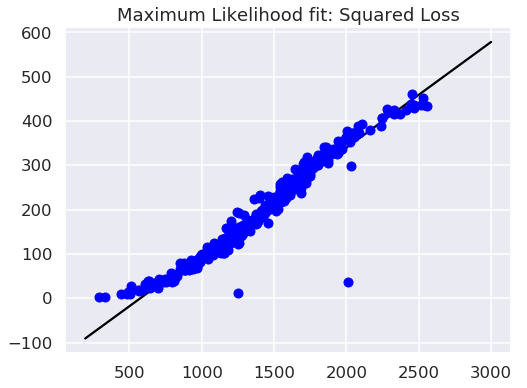

In [45]:
def residuals(theta, ELO=ELO, Win_Count=Win_Count, sigma0=sig0):
    """
    Residuals between data y (a vector at points x) and the theoretical model,
    which here is a straight line with theta[0] = b and theta[1] = m.
    """
    delta_y = Win_Count - theta[0] - theta[1] * ELO
    return delta_y / sigma0

 
def log_posterior_gaussian(theta):
    """
    Returns the logarithm of the posterior, with a standard chi^2 likelihood 
    in terms of the residuals, with Gaussian errors as specified and a
    uniform prior assumed for theta between 0 and 100.
    """
    if (all(theta > 0) and all(theta < 100)):
        return -0.5 * np.sum(residuals(theta)**2)
    else:
        return -np.inf  # recall log(0) = -inf  

def squared_loss(theta, ELO=ELO, Win_Count=Win_Count, sigma0=sig0):
    """Loss function is sum of squared residuals divided by 2, which
        is what we usually call chi^2 / 2. 
    """
    delta_y = Win_Count - theta[0] - theta[1] * ELO
    return np.sum(0.5 * (delta_y / sigma0) ** 2)

theta_MLE = optimize.fmin(squared_loss, [0, 0], disp=False)
print(f"MLE: theta0 = {theta_MLE[0]:.1f}, theta1 = {theta_MLE[1]:.2f}")

# Plot the MLE fit versus the data
xfit = np.linspace(195, 3000)
yfit = theta_MLE[0] + theta_MLE[1] * xfit

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.errorbar(ELO, Win_Count, sig0, fmt='o', color='blue')
ax.plot(xfit, yfit, color='black')
ax.set_title('Maximum Likelihood fit: Squared Loss');

Huber: theta0 = -149.2, theta1 = 0.25


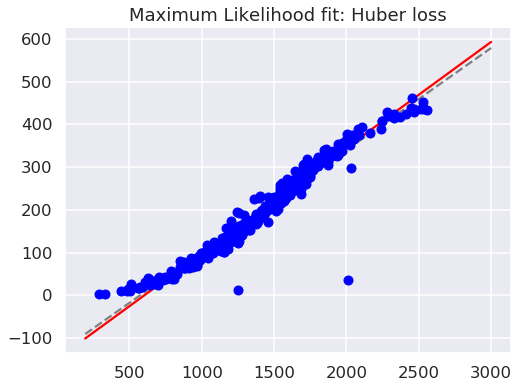

In [46]:
t = np.linspace(-20, 20)

def huber_loss(t, c=3):
    """
    Returns either a squared lost function or a linear (abolute value) loss
     function, depending on whether the |argument| is < c or >= c.
    """
    return ((abs(t) < c) * 0.5 * t ** 2
            + (abs(t) >= c) * -c * (0.5 * c - abs(t)))

def total_huber_loss(theta, ELO=ELO, Win_Count=Win_Count, sigma0=sig0, c=1):
    return huber_loss((Win_Count - theta[0] - theta[1] * ELO) / sigma0, c).sum()

# minimize the total Huber loss for c=3
theta2 = optimize.fmin(total_huber_loss, [0, 0], disp=False)
print(f"Huber: theta0 = {theta2[0]:.1f}, theta1 = {theta2[1]:.2f}")

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(ELO, Win_Count, sig0, fmt='o', color='blue')
ax.plot(xfit, theta_MLE[0] + theta_MLE[1] * xfit, color='gray',ls='--')
ax.plot(xfit, theta2[0] + theta2[1] * xfit, color='red')
ax.set_title('Maximum Likelihood fit: Huber loss');

## Class and Win Count 

MLE: theta0 = -792.7, theta1 = 4.53


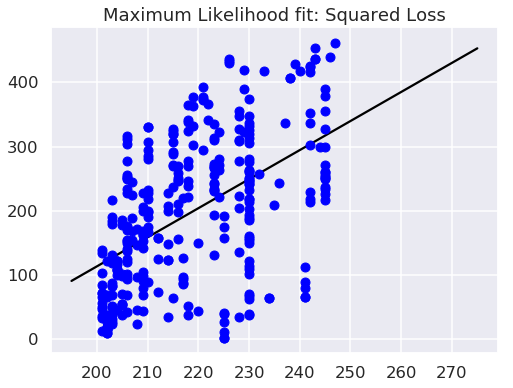

In [51]:
def residuals(theta, Class=Class, Win_Count=Win_Count, sigma0=sig0):
    """
    Residuals between data y (a vector at points x) and the theoretical model,
    which here is a straight line with theta[0] = b and theta[1] = m.
    """
    delta_y = Win_Count - theta[0] - theta[1] * Class
    return delta_y / sigma0

 
def log_posterior_gaussian(theta):
    """
    Returns the logarithm of the posterior, with a standard chi^2 likelihood 
    in terms of the residuals, with Gaussian errors as specified and a
    uniform prior assumed for theta between 0 and 100.
    """
    if (all(theta > 0) and all(theta < 100)):
        return -0.5 * np.sum(residuals(theta)**2)
    else:
        return -np.inf  # recall log(0) = -inf  

def squared_loss(theta, Class=Class, Win_Count=Win_Count, sigma0=sig0):
    """Loss function is sum of squared residuals divided by 2, which
        is what we usually call chi^2 / 2. 
    """
    delta_y = Win_Count - theta[0] - theta[1] * Class
    return np.sum(0.5 * (delta_y / sigma0) ** 2)

theta_MLE = optimize.fmin(squared_loss, [0, 0], disp=False)
print(f"MLE: theta0 = {theta_MLE[0]:.1f}, theta1 = {theta_MLE[1]:.2f}")

# Plot the MLE fit versus the data
xfit = np.linspace(195, 275)
yfit = theta_MLE[0] + theta_MLE[1] * xfit

fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.errorbar(Class, Win_Count, sig0, fmt='o', color='blue')
ax.plot(xfit, yfit, color='black')
ax.set_title('Maximum Likelihood fit: Squared Loss');

Huber: theta0 = -959.5, theta1 = 5.31


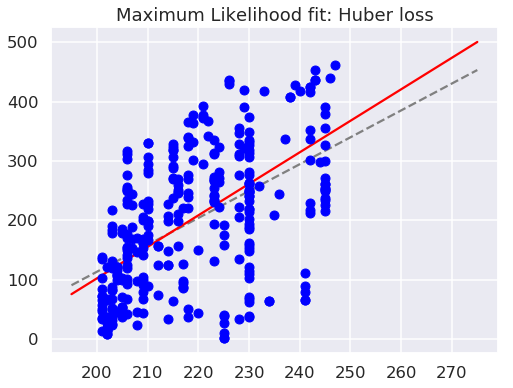

In [52]:
t = np.linspace(-20, 20)

def huber_loss(t, c=3):
    """
    Returns either a squared lost function or a linear (abolute value) loss
     function, depending on whether the |argument| is < c or >= c.
    """
    return ((abs(t) < c) * 0.5 * t ** 2
            + (abs(t) >= c) * -c * (0.5 * c - abs(t)))

def total_huber_loss(theta, Class=Class, Win_Count=Win_Count, sigma0=sig0, c=1):
    return huber_loss((Win_Count - theta[0] - theta[1] * Class) / sigma0, c).sum()

# minimize the total Huber loss for c=3
theta2 = optimize.fmin(total_huber_loss, [0, 0], disp=False)
print(f"Huber: theta0 = {theta2[0]:.1f}, theta1 = {theta2[1]:.2f}")

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.errorbar(Class, Win_Count, sig0, fmt='o', color='blue')
ax.plot(xfit, theta_MLE[0] + theta_MLE[1] * xfit, color='gray',ls='--')
ax.plot(xfit, theta2[0] + theta2[1] * xfit, color='red')
ax.set_title('Maximum Likelihood fit: Huber loss');

Not going to bother plotting the last plot because clearly I get the same results as above. 